In [1]:
import tensorflow as tf
from tensorflow.nn import softmax, dropout, relu
import tensorflow.keras.backend as K
from tensorflow import keras
from tensorflow.python.keras.layers import Layer, Embedding, GlobalAveragePooling1D, Dropout, Input, Dense
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.initializers import Ones, Zeros
%matplotlib inline

In [2]:
tf.__version__

'2.0.0-alpha0'

## Positional Encoding                                                                                                                                                                                                                        

                                                             
$$PE_{(pos,2i)} = sin(pos / 10000^{2i/d_{\text{model}}})$$

$$PE_{(pos,2i+1)} = cos(pos / 10000^{2i/d_{\text{model}}})$$                                                                                                                                       
                                                                                                                                

In [5]:
class Positional_Encoding(Layer):
    def __init__(self, d_model, max_len=5000, **kwargs):
        self.d_model = d_model
        position_matrix = np.zeros((max_len, d_model))
        position = np.arange(0., max_len).reshape(-1, 1)
        div_term = np.exp(np.arange(0., d_model, 2) * -
                          (np.log(10000.0) / d_model))
        position_matrix[:, 0::2] = np.sin(position * div_term)
        position_matrix[:, 1::2] = np.cos(position * div_term)
        self.position_matrix = np.expand_dims(position_matrix, axis=0)
        super(Positional_Encoding, self).__init__(**kwargs)

    def call(self, x):
        x = x+self.position_matrix[:, :x.shape[1], :]
        return x

#### example

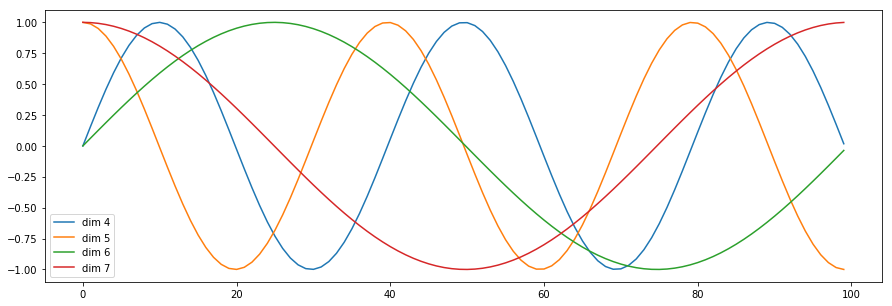

In [6]:
plt.figure(figsize=(15, 5))
pe = Positional_Encoding(20)
y = pe(np.zeros((1, 100, 20)))
plt.plot(np.arange(100), y[0, :, 4:8])
plt.legend(["dim %d"%p for p in [4,5,6,7]])
None

## Attention

### Dot Product Attention

$$                                                                         
   \mathrm{Attention}(Q, K, V) = \mathrm{softmax}(\frac{QK^T}{\sqrt{d_k}})V               
$$   

In [3]:
import pdb
def Dot_Product_Attention(query, key, value, mask=None,dropout_rate=None):
    d_k = query.shape[-1]
    
    len_dim=len(query.shape)
    perm=[i for i in range(len_dim-2)]
    perm.append(len_dim-1)
    perm.append(len_dim-2)
#     pdb.set_trace()
    
    scores = tf.matmul(query, tf.transpose(key, perm=perm)) / np.sqrt(d_k)
    
    # Reference: huggingface bert-pytorch-model
    # We create a 3D attention mask from a 2D tensor mask.
    # if do not use multihead:
    # Sizes are [batch_size,1, seq_length]
    # So we can broadcast to [batch_size,seq_length, seq_length]
    # if use multihead
    # Sizes are [batch_size, 1, 1, seq_length]
    # So we can broadcast to [batch_size, num_heads, seq_length, seq_length]
    # this attention mask is more simple than the triangular masking of causal attention
    # used in The annotated transformer, we just need to prepare the broadcast dimension here.
    if mask is not None:
        for _ in range(len_dim-len(mask.shape)):
            mask=tf.expand_dims(mask,axis=1)
        scores = scores+mask*-1e9

    attention = softmax(scores, axis=-1)
    print(attention)
    if dropout_rate is not None:
        attention = dropout(attention, rate=dropout_rate)
#     print(attention)
    output = tf.matmul(attention, value)
    return output

#### exmaple

In [4]:
word_index=np.array([[0,1,2,3],[0,0,1,2]])
word_vector=np.random.rand(2,4,6)
mask=(word_index==0).astype(float)

effect of mask

In [6]:
Dot_Product_Attention(word_vector,word_vector,word_vector,mask)
None

tf.Tensor(
[[[0.         0.34139598 0.34157104 0.31703299]
  [0.         0.34913113 0.37358548 0.27728339]
  [0.         0.29135149 0.42755099 0.28109752]
  [0.         0.28261278 0.36736494 0.35002228]]

 [[0.         0.         0.4648189  0.5351811 ]
  [0.         0.         0.49012617 0.50987383]
  [0.         0.         0.5007234  0.4992766 ]
  [0.         0.         0.39459366 0.60540634]]], shape=(2, 4, 4), dtype=float64)


### Multi-Head Attention

$$    
\mathrm{MultiHead}(Q, K, V) = \mathrm{Concat}(\mathrm{head_1}, ..., \mathrm{head_h})W^O    \\                                           
    \text{where}~\mathrm{head_i} = \mathrm{Attention}(QW^Q_i, KW^K_i, VW^V_i)                                
$$                                                                                                                 


In [100]:
class Multi_Head_Attention(Layer):
    def __init__(self, h, dropout_rate=0.1, **kwargs):
        self.dropout_rate = dropout_rate
        self.h = h
        super(Multi_Head_Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W_collection = []
        for weight in ['W_Q', 'W_K', 'W_V', 'W_O']:
            self.W_collection.append(self.add_weight(name=weight,
                                                     shape=(input_shape[0][-1], input_shape[0][-1]),
                                                     initializer='glorot_uniform',
                                                     trainable=True))
        super(Multi_Head_Attention, self).build(input_shape)

    def call(self, x):
        if len(x) == 3:
            query, key, value = x
            mask = None
        elif len(x) == 4:
            query, key, value, mask = x
        n_word = query.shape[-2]
        d_model = query.shape[-1]
        assert d_model % self.h == 0
        d_k = int(d_model/self.h)

        # 1) Do all the linear projections in batch from d_model => h x d_k             
        query, key, value = [tf.transpose(tf.reshape(K.dot(i, w),(-1, n_word, self.h, d_k)), perm=[0, 2, 1, 3]) 
                             for i, w in zip([query, key, value], self.W_collection)]
        

        # 2) Apply attention on all the projected vectors in batch.
        x = Dot_Product_Attention(query, key, value, mask=mask, dropout_rate=self.dropout_rate)

        # 3) "Concat" using a view and apply a final linear.
        x = tf.reshape(tf.transpose(x, perm=[0, 2, 1, 3]),(-1, n_word, int(self.h*d_k)))
        x = K.dot(x, self.W_collection[-1])
        if self.dropout_rate is not None:
            x = dropout(x, rate=self.dropout_rate)
        
        return x

#### example

In [101]:
test=Multi_Head_Attention(2,dropout_rate=0.1)
output=test([word_vector,word_vector,word_vector,mask])
output

<tf.Tensor: id=515, shape=(2, 4, 6), dtype=float64, numpy=
array([[[ 1.24973633,  0.08417207, -0.34166587,  0.53268429,
         -0.25602352, -0.43090583],
        [ 1.35267264, -0.08012357, -0.18254554,  0.54406129,
         -0.36932663, -0.30544288],
        [ 1.32869053, -0.0715992 , -0.18343388,  0.53491038,
         -0.36113386, -0.28077757],
        [ 1.3668201 , -0.07898381, -0.        ,  0.53767447,
         -0.36158414, -0.2964897 ]],

       [[ 0.87558162, -0.45423549, -0.05443675,  0.36865228,
         -0.30328809,  0.06565401],
        [ 1.32457069, -0.47716083, -0.09793503,  0.45086633,
         -0.34291306, -0.23739871],
        [ 0.        , -0.48188861, -0.        ,  0.4659411 ,
         -0.3352915 , -0.22803496],
        [ 1.05354896, -0.2201154 , -0.15413096,  0.444152  ,
         -0.40017438, -0.49936027]]])>

## Residual_Connection

In [11]:
class Residual_Connection (Layer):
    """
    A residual connection beforey a layer norm.
    """
    def __init__(self, **kwargs):
        super(Residual_Connection, self).__init__(**kwargs)

    def call(self, x):
        return tf.add(x[0], x[1])

    def compute_output_shape(self, input_shape):
        return input_shape[0]

#### example

In [12]:
res_result=Residual_Connection()([word_vector,output])
res_result

<tf.Tensor: id=263, shape=(2, 4, 6), dtype=float64, numpy=
array([[[ 0.60810716,  0.39080482,  0.31994018,  0.59371478,
          0.61136336,  0.75788936],
        [-0.25025245,  0.37730023,  0.17959904,  0.72615399,
          1.52943055,  0.20506895],
        [-0.04368544,  0.19865132,  0.30631159,  0.31741982,
          1.07036643,  0.67907699],
        [ 0.03978968,  0.30947838,  0.12058452,  0.97710896,
          1.60939434,  0.67369582]],

       [[ 0.31941247,  0.50554412,  0.63586861,  0.45951651,
          0.89086837,  0.73515903],
        [-0.49643626,  0.79580882, -0.05731663,  0.60062256,
          1.16732561,  0.66126889],
        [-0.42873999,  0.02959333, -0.10790047,  1.10995513,
          1.3009093 ,  0.65979033],
        [ 0.07657397,  0.64107017,  0.34918156,  1.19587981,
          0.46420654,  0.843261  ]]])>

## LayerNormalization

In [13]:
class LayerNormalization(Layer):
	def __init__(self, eps=1e-6, **kwargs):
		self.eps = eps
		super(LayerNormalization, self).__init__(**kwargs)
	def build(self, input_shape):
		self.gamma = self.add_weight(name='gamma', shape=input_shape[-1:],
									 initializer=Ones(), trainable=True)
		self.beta = self.add_weight(name='beta', shape=input_shape[-1:],
									initializer=Zeros(), trainable=True)
		super(LayerNormalization, self).build(input_shape)
	def call(self, x):
		mean = K.mean(x, axis=-1, keepdims=True)
		std = K.std(x, axis=-1, keepdims=True)
		return self.gamma * (x - mean) / (std + self.eps) + self.beta
	def compute_output_shape(self, input_shape):
		return input_shape

#### example

In [14]:
normalize_result=LayerNormalization()(res_result)
normalize_result

<tf.Tensor: id=299, shape=(2, 4, 6), dtype=float64, numpy=
array([[[ 0.41456796, -1.05894666, -1.5394757 ,  0.31697401,
          0.43664804,  1.43023234],
        [-1.27460944, -0.15033785, -0.50452299,  0.47463975,
          1.91372373, -0.4588932 ],
        [-1.2918356 , -0.61865102, -0.31958277, -0.28872533,
          1.80287665,  0.71591807],
        [-1.06480567, -0.57129619, -0.91695737,  0.65041615,
          1.80744953,  0.09519356]],

       [[-1.4483446 , -0.45595102,  0.23889685, -0.70135532,
          1.59847289,  0.7682812 ],
        [-1.69378289,  0.63063305, -0.90391981,  0.27954326,
          1.29889602,  0.38863038],
        [-1.33667362, -0.62097691, -0.83567624,  1.0660298 ,
          1.36420858,  0.3630884 ],
        [-1.44619457,  0.12842914, -0.68577424,  1.67603287,
         -0.3649199 ,  0.6924267 ]]])>

## Position-wise Feed-Forward

$$\mathrm{FFN}(x)=\max(0, xW_1 + b_1) W_2 + b_2$$                                                                                                               

In [15]:
class Position_wise_Feed_Forward(Layer):

    def __init__(self,  d_ff=512, dropout_rate=0.1, **kwargs):
        self.d_ff = d_ff
        self.dropout_rate = dropout_rate
        super(Position_wise_Feed_Forward, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.W_l = self.add_weight(name='W_1',
                                   shape=(input_shape[-1], self.d_ff),
                                   initializer='glorot_uniform',
                                   trainable=True)
        self.b_1 = self.add_weight(name='b_1',
                                   shape=(self.d_ff,),
                                   initializer='zeros',
                                   trainable=True)
        self.W_2 = self.add_weight(name='W_2',
                                   shape=(self.d_ff, input_shape[-1]),
                                   initializer='glorot_uniform',
                                   trainable=True)
        self.b_2 = self.add_weight(name='b21',
                                   shape=(input_shape[-1],),
                                   initializer='zeros',
                                   trainable=True)
        super(Position_wise_Feed_Forward, self).build(input_shape)  

    def call(self, x):
        linear_1 =K.dot(x, self.W_l)+self.b_1
        linear_1 = relu(linear_1)
        linear_1 = dropout(linear_1, rate=self.dropout_rate)
        linear_2 = K.dot(linear_1, self.W_2)+self.b_2
        return linear_2

#### example 

In [16]:
Feed_Forward_result=Position_wise_Feed_Forward()(normalize_result)
Feed_Forward_result

<tf.Tensor: id=398, shape=(2, 4, 6), dtype=float64, numpy=
array([[[ 0.15394318, -0.01356441, -0.01140072,  0.01499302,
          0.24378344,  0.08654821],
        [-0.05346704,  0.03210006,  0.37578066,  0.01326718,
          0.29009592,  0.34142417],
        [-0.01074461,  0.04416184,  0.23730452, -0.00956024,
          0.24415151,  0.22873397],
        [ 0.0142921 ,  0.11510237,  0.32731883, -0.09767013,
          0.25278746,  0.16873702]],

       [[-0.10407445,  0.05348779,  0.1700495 ,  0.1594913 ,
          0.32192225,  0.15465696],
        [-0.11412109,  0.05348618,  0.33304111, -0.04599716,
          0.18830327,  0.35478855],
        [-0.01343834,  0.0335287 ,  0.28419211, -0.09584151,
          0.2704192 ,  0.10237414],
        [ 0.1556131 ,  0.0375446 ,  0.13921401, -0.40711135,
          0.14085739, -0.03704817]]])>

## Combine parts into encoder

In [17]:
def encoder(x):
    x=Residual_Connection()([Multi_Head_Attention(h=2)([x,x,x]),x])
    x=LayerNormalization()(x)
    x=Residual_Connection()([Position_wise_Feed_Forward()(x),x])
    x=LayerNormalization()(x)
    return x


#### example

In [18]:
encoder(word_vector)

<tf.Tensor: id=746, shape=(2, 4, 6), dtype=float64, numpy=
array([[[-0.71249195, -0.75073613,  0.66806039, -1.30726891,
          1.58195479,  0.52048182],
        [-1.44444877, -0.13506163,  0.84858547, -0.40988725,
          1.6558747 , -0.51506252],
        [-1.3404167 , -0.28875688,  1.39009392, -1.11212975,
          0.53810235,  0.81310706],
        [-1.58614807, -0.51462534,  0.84418757, -0.13610789,
          1.56764138, -0.17494765]],

       [[-0.09131305,  0.55521607,  0.0344577 , -1.87992935,
          1.46334434, -0.08177571],
        [-1.30541035,  1.64055359,  0.01640854, -1.10997697,
          0.17359899,  0.5848262 ],
        [-1.43961414, -0.55047345,  0.53515361, -0.61481788,
          1.6744666 ,  0.39528526],
        [-1.61091115,  1.38250497, -0.10893484, -0.86224893,
          0.6967123 ,  0.50287765]]])>

## Real Word example

In [19]:
from __future__ import print_function
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Model
max_features = 20000
batch_size = 1024
maxlen = 80

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)


Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
x_train shape: (25000, 80)
x_test shape: (25000, 80)


In [20]:
# define model
S_inputs = Input(shape=(maxlen,), dtype='int32')
embeddings = Embedding(max_features, 128)(S_inputs)
embeddings=Positional_Encoding(d_model=128)(embeddings)
O_seq=encoder(embeddings)
O_seq = GlobalAveragePooling1D()(O_seq)
O_seq = Dropout(0.5)(O_seq)
outputs = Dense(1, activation='sigmoid')(O_seq)

model = Model(inputs=S_inputs, outputs=outputs)


In [21]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 80)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 80, 128)      2560000     input_1[0][0]                    
__________________________________________________________________________________________________
positional__encoding_1 (Positio (None, 80, 128)      0           embedding[0][0]                  
__________________________________________________________________________________________________
multi__head__attention_2 (Multi (None, 80, 128)      65536       positional__encoding_1[0][0]     
                                                                 positional__encoding_1[0][0] 

In [22]:
# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
print('Train...')
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=20,
          validation_data=(x_test, y_test))

Train...
Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 [==============================] - 30s 1ms/sample - loss: 0.8781 - accuracy: 0.4955 - val_loss: 0.7094 - val_accuracy: 0.5000
Epoch 2/20
25000/25000 [==============================] - 31s 1ms/sample - loss: 0.7151 - accuracy: 0.5100 - val_loss: 0.6903 - val_accuracy: 0.5000
Epoch 3/20
25000/25000 [==============================] - 31s 1ms/sample - loss: 0.6991 - accuracy: 0.5116 - val_loss: 0.6863 - val_accuracy: 0.6718
Epoch 4/20
25000/25000 [==============================] - 28s 1ms/sample - loss: 0.6847 - accuracy: 0.5533 - val_loss: 0.6690 - val_accuracy: 0.6931
Epoch 5/20
25000/25000 [==============================] - 31s 1ms/sample - loss: 0.5957 - accuracy: 0.7048 - val_loss: 0.4494 - val_accuracy: 0.7940
Epoch 6/20
25000/25000 [==============================] - 25s 1ms/sample - loss: 0.3748 - accuracy: 0.8346 - val_loss: 0.3519 - val_accuracy: 0.8428
Epoch 7/20
25000/25000 [=======================

KeyboardInterrupt: 

#### visulize model

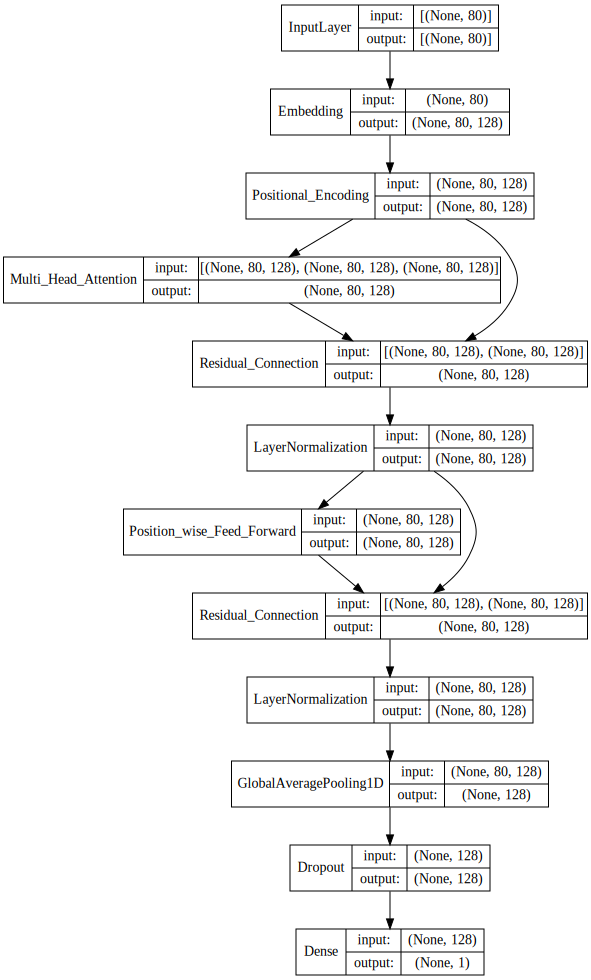

In [23]:
from IPython.display import SVG
from tensorflow.python.keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model, show_shapes=True,show_layer_names=False).create(prog='dot', format='svg'))

In [24]:
keras.utils.plot_model(model, "attention.png", show_shapes=True,show_layer_names=False)